In [145]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv("train.csv",index_col="Id")
test = pd.read_csv("test.csv",index_col="Id")

def print_full(x):
    """
    Full printing of dataframes for error checking
    """
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')

def clean(df):
    """
    Cleans NaNs and creates new features
    """
    
    # List of new features to be created: (new_feature, original_feature, transform_function)
    transform = [("sqLotArea","LotArea",np.sqrt),
                 ("sqGrLivArea","GrLivArea",np.sqrt),
                 ("sqBsmtFinSF1","BsmtFinSF1",np.sqrt),
                 ("sqBsmtFinSF2","BsmtFinSF2",np.sqrt),
                 ("sqBsmtUnfSF","BsmtUnfSF",np.sqrt),
                 ("sqTotalBsmtSF","TotalBsmtSF",np.sqrt),
                 ("sq1stFlrSF","1stFlrSF",np.sqrt),
                 ("sq2ndFlrSF","2ndFlrSF",np.sqrt),
                 ("sqLotFrontage","LotFrontage",np.sqrt),
                 ("sqMasVnrArea","MasVnrArea",np.sqrt),
                 ("sqPoolArea","PoolArea",np.sqrt),
                 ("sqGarageArea","GarageArea",np.sqrt),
                 ("sqWoodDeckSF","WoodDeckSF",np.sqrt),
                 ("sqOpenPorchSF","OpenPorchSF",np.sqrt),
                 ("sqEnclosedPorch","EnclosedPorch",np.sqrt),
#                  ("expLotArea","LotArea",np.exp),
#                  ("expGrLivArea","GrLivArea",np.exp),
#                  ("expBsmtFinSF1","BsmtFinSF1",np.exp),
#                  ("expBsmtFinSF2","BsmtFinSF2",np.exp),
#                  ("expBsmtUnfSF","BsmtUnfSF",np.exp),
#                  ("expTotalBsmtSF","TotalBsmtSF",np.exp),
#                  ("exp1stFlrSF","1stFlrSF",np.exp),
#                  ("exp2ndFlrSF","2ndFlrSF",np.exp),
#                  ("expLotFrontage","LotFrontage",np.exp),
#                  ("expMasVnrArea","MasVnrArea",np.exp),
#                  ("expPoolArea","PoolArea",np.exp),
#                  ("expGarageArea","GarageArea",np.exp),
#                  ("expWoodDeckSF","WoodDeckSF",np.exp),
#                  ("expOpenPorchSF","OpenPorchSF",np.exp),
#                  ("expEnclosedPorch","EnclosedPorch",np.exp),
                 ("lnLotArea","LotArea",np.log1p),
                 ("lnGrLivArea","GrLivArea",np.log1p),
                 ("lnBsmtFinSF1","BsmtFinSF1",np.log1p),
                 ("lnBsmtFinSF2","BsmtFinSF2",np.log1p),
                 ("lnBsmtUnfSF","BsmtUnfSF",np.log1p),
                 ("lnTotalBsmtSF","TotalBsmtSF",np.log1p),
                 ("ln1stFlrSF","1stFlrSF",np.log1p),
                 ("ln2ndFlrSF","2ndFlrSF",np.log1p),
                 ("lnLotFrontage","LotFrontage",np.log1p),
                 ("lnMasVnrArea","MasVnrArea",np.log1p),
                 ("lnPoolArea","PoolArea",np.log1p),
                 ("lnGarageArea","GarageArea",np.log1p),
                 ("lnWoodDeckSF","WoodDeckSF",np.log1p),
                 ("lnOpenPorchSF","OpenPorchSF",np.log1p),
                 ("lnEnclosedPorch","EnclosedPorch",np.log1p),
                ]
    
    # Find categorical and numerical features
    categoricals = train.select_dtypes(include=["object"]).columns.values
    numericals = [feat for feat in train.select_dtypes(include=["int","float"]).columns.values]
    
    # Remove NaNs... bear in mind this is a rough script. I recommend a more intelligent way of doing this,
    # for example a feature like LotFrontage may be NaN because the property has no Lot Frontage, so it makes
    # more sense to set this to zero instead of imputing the median value as shown below.
    
    # Transform to create new features, scale using MinMaxScaler
    for (new_feature,original_feature,f) in transform: 
        df[new_feature] = df[original_feature].fillna(df[original_feature].median(), inplace = False)
        df[new_feature] = MinMaxScaler().fit_transform(f(df[new_feature].apply(float)).reshape(-1,1))
    # Scale and remove NaNs for numerical features by imputing median value
    for feature in numericals: 
        df[feature].fillna(df[feature].median(), inplace = True)
        df[feature] = MinMaxScaler().fit_transform(df[feature].apply(float).reshape(-1,1))
    # Impute NaNs for categorical features
    for feature in categoricals: 
        df[feature].fillna(df[feature].value_counts().idxmax(), inplace = True)
    # Perform one hot encoding on the categorical features
    for cat in categoricals:
        dummies = pd.get_dummies(df[cat])
        dummies.columns = [col_name + cat for col_name in dummies.columns.values]            
        df = df.drop(cat,axis=1)
        df = df.join(dummies)
    return df

target = train["SalePrice"] # Note that we will take the Log of this when fitting - check the histogram of this feature
train = train.drop("SalePrice",axis=1)

dd = clean(pd.concat([train,test]))

train = dd[:len(train)]
test = dd[len(train):]

In [146]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.cross_validation import cross_val_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

def rmse_cv(model,X,y): # Cross val using the competition scoring metric
    return(np.sqrt(-cross_val_score(model, X, np.log(y), scoring="mean_squared_error", cv = 5)))

# def rmse(actual,pred):
#     return(np.sqrt( ( (actual-pred)**2).mean()))


# dtrain = xgb.DMatrix(train)
# dtarget = xgb.DMatrix(target)
# dtest =  xgb.DMatrix(test)

cv_params = {'learning_rate':[0.01,0.07,0.1],} #, 'min_child_weight': [1,3,5]}
ind_params = {'max_depth': 3,
              'n_estimators': 6000,
              'seed':0,
              "subsample": 0.8,
              "colsample_bytree": 0.8,
              "colsample_bylevel": 0.8, 
             'objective': 'reg:linear'}

# optimized_xgb = GridSearchCV(xgb.XGBRegressor(**ind_params), 
#                             cv_params, 
#                             scoring = 'mean_squared_error', cv = 3, n_jobs = -1) 

# optimized_xgb.fit(train, target)
# print(optimized_xgb.best_params_)
# stop

model = xgb.XGBRegressor(
                 gamma=0.030,                 
                 learning_rate=0.01,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.8,
                 colsample_bytree= 0.8,
                 colsample_bylevel= 0.8,
                )

model.fit(train,np.log(target))
preds = np.exp(model.predict(test))



from sklearn.linear_model import ElasticNet
model2 = ElasticNet(alpha=0.0009).fit(train,np.log(target))
model2.fit(train,np.log(target))
preds2 = np.exp(model2.predict(test))


results = (preds + preds2) / 2.0


In [10]:
from sklearn.ensemble import RandomForestRegressor

params = {"n_jobs": -1,
         "n_estimators": 1000,
         "max_features": "auto",
          "min_samples_leaf": 5,
          "oob_score": True,
          "random_state" : 42
         }

rf_model = RandomForestRegressor(**params)

rf_model.fit(train,np.log(target))
pred_rf = np.exp(rf_model.predict(test))

/home/james/anaconda3/lib/python3.5/site-packages/keras/models.py:603: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 1314 samples, validate on 146 samples
Epoch 1/10000
0s - loss: 140.6711 - val_loss: 118.6925
Epoch 2/10000
0s - loss: 119.3671 - val_loss: 104.5505
Epoch 3/10000
0s - loss: 105.1846 - val_loss: 92.3521
Epoch 4/10000
0s - loss: 92.9484 - val_loss: 81.2514
Epoch 5/10000
0s - loss: 81.8104 - val_loss: 71.1430
Epoch 6/10000
0s - loss: 71.6653 - val_loss: 62.0873
Epoch 7/10000
0s - loss: 62.5744 - val_loss: 54.1234
Epoch 8/10000
0s - loss: 54.5771 - val_loss: 47.2122
Epoch 9/10000
0s - loss: 47.6351 - val_loss: 41.2467
Epoch 10/10000
0s - loss: 41.6413 - val_loss: 36.0870
Epoch 11/10000
0s - loss: 36.4555 - val_loss: 31.5944
Epoch 12/10000
0s - loss: 31.9387 - val_loss: 27.6497
Epoch 13/10000
0s - loss: 27.9713 - val_loss: 24.1571
Epoch 14/10000
0s - loss: 24.4574 - val_loss: 21.0436
Epoch 15/10000
0s - loss: 21.3236 - val_loss: 18.2566
Epoch 16/10000
0s - loss: 18.5171 - val_loss: 15.7601
Epoch 17/10000
0s - loss: 16.0018 - val_loss: 13.5285
Epoch 18/10000
0s - loss: 13.7521 - val

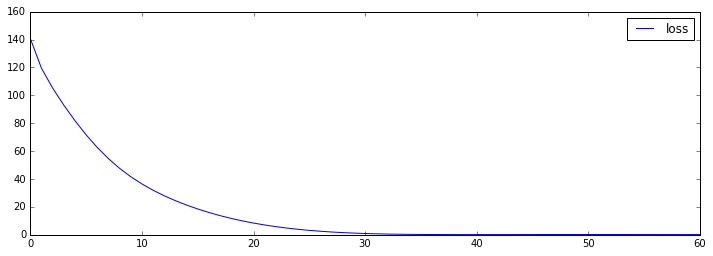

In [132]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.objectives import MSE, MAE
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import LSTM

model = Sequential()

from keras.layers import Dense, Activation

import theano.tensor as T

def custom_loss(y_true,y_pred):  
    return T.mean(T.square(y_pred - y_true), axis=-1)
    #return T.sum(T.dot(y_true,T.transpose(T.square(T.square(y_pred) - T.square(y_true)))), axis=-1)  
    #return loss  


in_out_neurons = 318
hidden_neurons = 300

# model = Sequential()  
# model.add(LSTM(input_dim=train.shape[1], output_dim=hidden_neurons, return_sequences=False))  
# model.add(Dense(input_dim=hidden_neurons, output_dim=1))  
# model.add(Activation("linear"))  
# model.compile(loss="mean_squared_error", optimizer="rmsprop")  
    
    
model = Sequential()
#model.add(Dense(input_dim=in_out_neurons, output_dim=hidden_neurons, return_sequences=False))
model.add(Dense(input_dim=in_out_neurons, output_dim=128,init="uniform"))  
model.add(Activation("sigmoid"))
model.add(Dense(output_dim=hidden_neurons))  
model.add(Activation("sigmoid"))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))
#model.add(Dropout(0.1))
  
#model.add(Dense(output_dim=int())
# model.add(Activation("relu"))
# #model.add(Dropout(0.1))


# model.add(Dense(output_dim=int(2*(train.shape[1]))))
# model.add(Activation("relu"))
#model.add(Dropout(0.1))


#model.add(Dense(output_dim=1))


# model.compile("nadam", loss=custom_loss)

model.compile(loss="mean_squared_error", optimizer="nadam")  
    

early_stopping = EarlyStopping(monitor='loss', patience=20)

train_log = model.fit(np.array((train)), (np.log(target)),
                          batch_size=32,
                          nb_epoch=1000, validation_split=0.1,
                          verbose=2,
                          shuffle=True,
                          show_accuracy = True,
                          callbacks=[early_stopping]
                          )

#loss_and_metrics = model.evaluate(np.array(train), np.array(target))
#print(loss_and_metrics)

plt.plot(train_log.history["loss"], label="loss")
#plt.plot(train_log.history["val_loss"], label="val_loss")
plt.legend()
pred_nn = np.exp(model.predict(np.array(test)))
#print(Y_pred_nn)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta
from keras.layers.normalization import BatchNormalization

class NN:
    #Wrapper for Keras NN
    #See http://keras.io/ for parameter options
    def __init__(self, inputShape, layers, dropout = [],
                 activation = 'relu', init = 'uniform', loss = 'rmse',
                 optimizer = 'adadelta', nb_epochs = 50, batch_size = 32, verbose = 1,
                 patience=10):

        model = Sequential()
        for i in range(len(layers)):
            if i == 0:
                print ("Input shape: " + str(inputShape))
                print ("Adding Layer " + str(i) + ": " + str(layers[i]))
                model.add(Dense(layers[i], input_dim = inputShape, init = init))
            else:
                print ("Adding Layer " + str(i) + ": " + str(layers[i]))
                model.add(Dense(layers[i], init = init))
            print ("Adding " + activation + " layer")
            model.add(Activation(activation))
            model.add(BatchNormalization())
            if len(dropout) > i:
                print ("Adding " + str(dropout[i]) + " dropout")
                model.add(Dropout(dropout[i]))
        model.add(Dense(1, init = init)) #End in a single output node for regression style output
        model.compile(loss=loss, optimizer=optimizer)
        
        self.patience = patience
        self.model = model
        self.nb_epochs = nb_epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y): 
        
        early_stopping = EarlyStopping(monitor='loss', patience=self.patience)

        self.model.fit(X,y,
                       nb_epoch=self.nb_epochs, batch_size=self.batch_size, verbose = self.verbose,
                       callbacks=[early_stopping]
                      )
        
    def predict(self, X, batch_size = 128, verbose = 1):
        return self.model.predict(X, batch_size = batch_size, verbose = verbose)

model = NN(inputShape = train.shape[1],
         layers = [256,128,64],
         dropout = [0.33,0.33,0.33],
         loss="mean_squared_error",
         optimizer = 'nadam',
         init = 'uniform',
         batch_size = 32,
         nb_epochs = 5000,
          patience=100)


train_log = model.fit(np.array((train)), (np.log(target)),
                          
                          #verbose=2,
                          #shuffle=True,
                          #show_accuracy = True,
                          #callbacks=[early_stopping]
                          )

pred_nn = np.exp(model.predict(np.array(test)))

#plt.plot(train_log.history["loss"], label="loss")
#plt.plot(train_log.history["val_loss"], label="val_loss")
plt.legend()
#print(Y_pred_nn)

Input shape: 318
Adding Layer 0: 256
Adding relu layer
Adding 0.33 dropout
Adding Layer 1: 128
Adding relu layer
Adding 0.33 dropout
Adding Layer 2: 64
Adding relu layer
Adding 0.33 dropout
Epoch 1/5000
1460/1460 [==============================] - 0s - loss: 141.7184     
Epoch 2/5000
1460/1460 [==============================] - 0s - loss: 121.0507     
Epoch 3/5000
1460/1460 [==============================] - 0s - loss: 69.3797     
Epoch 4/5000
1460/1460 [==============================] - 0s - loss: 22.1645     
Epoch 5/5000
1460/1460 [==============================] - 0s - loss: 6.0962     
Epoch 6/5000
1460/1460 [==============================] - 0s - loss: 4.3373     
Epoch 7/5000
1460/1460 [==============================] - 0s - loss: 3.7301     
Epoch 8/5000
1460/1460 [==============================] - 0s - loss: 3.8520     
Epoch 9/5000
1460/1460 [==============================] - 0s - loss: 3.5157     
Epoch 10/5000
1460/1460 [==============================] - 0s - loss: 3.024

In [212]:
y_pred = ((preds+preds2+pred_nn.T)/3.0)[0]
# print(y_pred)
# Output to CSV
pred_df = pd.DataFrame(y_pred, index=test.index.values, columns=["SalePrice"])
pred_df.to_csv('submit.txt', header=True, index_label='Id')

In [213]:
sum(preds-preds2)

61940.504302661626

In [214]:
sum((preds - pred_nn.T)[0])

-2019508.150390625

In [215]:
 pred_nn.T

array([[ 134089.53125  ,  149049.109375 ,  186540.75     , ...,
         182405.234375 ,  121760.2578125,  198176.390625 ]], dtype=float32)